Based on https://docs.dgl.ai/en/0.8.x/guide/training-edge.html#:~:text=DGL%20provides%20Graph%20Convolutional%20Matrix,predictor%20module%20is%20called%20BiDecoder%20.

The idea is to train an RGCN to learn node representations, and use these node representations to get a link prediction.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installing DGL
! pip install  dgl -f https://data.dgl.ai/wheels/repo.html
! pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn

In [4]:
import pandas as pd
import numpy as np

In [5]:
dgl.seed(42)
torch.manual_seed(42)

In [6]:
from dgl.data.utils import load_graphs
glist, label_dict = load_graphs("./drive/MyDrive/CS6208 Project/Graph Construction/saved_graph.bin")
g = glist[0]

Adding train and test masks

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response_test.csv')

In [8]:
used_node_idx = 0
node2idx_gene = {}

gene_node_df = pd.read_csv('./drive/MyDrive/CS6208 Project/node_features/gene_node_features.csv')
for gname in set(gene_node_df['genes'].tolist()):
    # print(cl); break
    node2idx_gene[gname] = used_node_idx
    used_node_idx += 1

print("Num of unique genes: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))

Num of unique genes: 27236 | Node indices: 0 to 27235



In [9]:
used_node_idx = 0
node2idx_cellLine = {}

cell_line_nodes_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/node_features/cell_line_node_features.csv')
for cl in set(cell_line_nodes_df['ModelID'].tolist()):
    # print(cl); break
    node2idx_cellLine[cl] = used_node_idx
    used_node_idx += 1

print("Num of unique cell lines: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))

Num of unique cell lines: 1710 | Node indices: 0 to 1709



In [10]:
used_node_idx = 0
node2idx_drug = {}

drug_node_df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/node_features/drug_node_features.csv')
for dname in set(drug_node_df['Name'].tolist()):
    # print(cl); break
    node2idx_drug[dname] = used_node_idx
    used_node_idx += 1

print("Num of unique drugs: {} | Node indices: {} to {}\n".format(used_node_idx, 0, used_node_idx-1))


Num of unique drugs: 1889 | Node indices: 0 to 1888



In [11]:
from tqdm import tqdm

In [12]:
def get_train_test_edge_masks(g):
    df = pd.read_csv('/content/drive/MyDrive/CS6208 Project/link_features/cl_drug_response.csv')
    feat_column_list = ['AUC']
    num_feats = len(feat_column_list)

    train_mask = []

    for key, row in tqdm(df.iterrows()):
        cl = row['DepMap_ID']
        drug = row['DRUG_NAME']
        
        subset_df_train = train_df[(train_df.DepMap_ID == cl)&(train_df.DRUG_NAME == drug)]
        subset_df_test = test_df[(test_df.DepMap_ID == cl)&(test_df.DRUG_NAME == drug)]
        if len(subset_df_train) != 0:
          train_mask.append(1)
        else:
          train_mask.append(0)
    train_mask = torch.tensor(train_mask)
    test_mask = 1 - train_mask
    g.edges[('cell_line', 'response', 'drug')].data["train_mask"] = train_mask
    g.edges[('cell_line', 'response', 'drug')].data["test_mask"] = test_mask
    return g

In [13]:
g = get_train_test_edge_masks(g)

45083it [06:50, 109.80it/s]


In [14]:
g

Graph(num_nodes={'cell_line': 1710, 'drug': 1889, 'gene': 27236},
      num_edges={('cell_line', 'mutates', 'gene'): 1183425, ('cell_line', 'response', 'drug'): 45083, ('drug', 'interacts', 'drug'): 44104, ('drug', 'interacts', 'gene'): 11370, ('gene', 'interacts', 'gene'): 11937785},
      metagraph=[('cell_line', 'gene', 'mutates'), ('cell_line', 'drug', 'response'), ('gene', 'gene', 'interacts'), ('drug', 'drug', 'interacts'), ('drug', 'gene', 'interacts')])

In [15]:
# create a new heterograph with reverse edges added in
# https://discuss.dgl.ai/t/dglheterograph-how-to-add-new-edge-types-especially-reverse-edges/1408/6
def add_reverse_hetero(g):
    relations = {}
    num_nodes_dict = {ntype: g.num_nodes(ntype) for ntype in g.ntypes}
    for metapath in [('cell_line', 'mutates', 'gene'), ('cell_line', 'response', 'drug'), ('drug', 'interacts', 'drug'), \
                         ('drug', 'interacts', 'gene'), ('gene', 'interacts', 'gene')]:
        # Original edges
        print(metapath)
        src, dst = g.all_edges(etype=metapath)
        relations[metapath] = (src, dst)

        reverse_metapath = (metapath[2], metapath[1] + '_by', metapath[0])
        relations[reverse_metapath] = (dst, src)           # Reverse edges

    new_g = dgl.heterograph(relations, num_nodes_dict=num_nodes_dict)

    # copy_ndata:
    for ntype in g.ntypes:
        for k, v in g.nodes[ntype].data.items():
            new_g.nodes[ntype].data[k] = v.detach().clone()

    # copy edata
    # new_g.edges[('cell_line', 'mutates', 'gene')].data["he"] = g.edges[('cell_line', 'mutates', 'gene')].data["he"]
    for e in [('cell_line', 'mutates', 'gene'), ('cell_line', 'response', 'drug'), ('drug', 'interacts', 'drug'), \
                         ('drug', 'interacts', 'gene'), ('gene', 'interacts', 'gene')]:
        print(e)
        for k, v in g.edges[e].data.items():
            new_g.edges[e].data[k] = v.detach().clone()
            new_g.edges[(e[2], e[1]+ "_by", e[0])].data[k] = v.detach().clone()
        # new_g.edges[eval(f"({e[2]}, {e[1]}+ '_by', {e[0]})")].data["he"] = g.edges(e).data["he"]
        # new_g.edges[eval(e)].data["he"] = g.edges(e).data["he"]

    return new_g
new_g = add_reverse_hetero(g)

('cell_line', 'mutates', 'gene')
('cell_line', 'response', 'drug')
('drug', 'interacts', 'drug')
('drug', 'interacts', 'gene')
('gene', 'interacts', 'gene')
('cell_line', 'mutates', 'gene')
('cell_line', 'response', 'drug')
('drug', 'interacts', 'drug')
('drug', 'interacts', 'gene')
('gene', 'interacts', 'gene')


In [16]:
new_g#.edges[('drug', 'response_by', 'cell_line')]

Graph(num_nodes={'cell_line': 1710, 'drug': 1889, 'gene': 27236},
      num_edges={('cell_line', 'mutates', 'gene'): 1183425, ('cell_line', 'response', 'drug'): 45083, ('drug', 'interacts', 'drug'): 44104, ('drug', 'interacts', 'gene'): 11370, ('drug', 'interacts_by', 'drug'): 44104, ('drug', 'response_by', 'cell_line'): 45083, ('gene', 'interacts', 'gene'): 11937785, ('gene', 'interacts_by', 'drug'): 11370, ('gene', 'interacts_by', 'gene'): 11937785, ('gene', 'mutates_by', 'cell_line'): 1183425},
      metagraph=[('cell_line', 'gene', 'mutates'), ('cell_line', 'drug', 'response'), ('gene', 'gene', 'interacts'), ('gene', 'gene', 'interacts_by'), ('gene', 'drug', 'interacts_by'), ('gene', 'cell_line', 'mutates_by'), ('drug', 'drug', 'interacts'), ('drug', 'drug', 'interacts_by'), ('drug', 'gene', 'interacts'), ('drug', 'cell_line', 'response_by')])

In [17]:
new_g.edges[('drug', 'response_by', 'cell_line')].data

{'he': tensor([[0.5976],
        [0.7781],
        [0.9532],
        ...,
        [0.8462],
        [0.9204],
        [0.9948]], dtype=torch.float64), 'train_mask': tensor([0, 1, 1,  ..., 1, 1, 1]), 'test_mask': tensor([1, 0, 0,  ..., 0, 0, 0])}

In [18]:
new_g.edges[('cell_line', 'response', 'drug')].data

{'he': tensor([[0.5976],
        [0.7781],
        [0.9532],
        ...,
        [0.8462],
        [0.9204],
        [0.9948]], dtype=torch.float64), 'train_mask': tensor([0, 1, 1,  ..., 1, 1, 1]), 'test_mask': tensor([1, 0, 0,  ..., 0, 0, 0])}

In [19]:
g

Graph(num_nodes={'cell_line': 1710, 'drug': 1889, 'gene': 27236},
      num_edges={('cell_line', 'mutates', 'gene'): 1183425, ('cell_line', 'response', 'drug'): 45083, ('drug', 'interacts', 'drug'): 44104, ('drug', 'interacts', 'gene'): 11370, ('gene', 'interacts', 'gene'): 11937785},
      metagraph=[('cell_line', 'gene', 'mutates'), ('cell_line', 'drug', 'response'), ('gene', 'gene', 'interacts'), ('drug', 'drug', 'interacts'), ('drug', 'gene', 'interacts')])

In [20]:
# g.nodes["cell_line"].data["hv"] = g.nodes["cell_line"].data["hv"].to(torch.float32)
g.nodes["drug"].data["hv"] = g.nodes["drug"].data["hv"].to(torch.float32)
g.nodes["gene"].data["hv"] = g.nodes["gene"].data["hv"].to(torch.float32)

In [21]:
new_g.nodes["cell_line"].data["hv"] = new_g.nodes["cell_line"].data["hv"].to(torch.float32)
new_g.nodes["drug"].data["hv"] = new_g.nodes["drug"].data["hv"].to(torch.float32)
new_g.nodes["gene"].data["hv"] = new_g.nodes["gene"].data["hv"].to(torch.float32)

In [22]:
# g.nodes["cell_line"].data["hv"].shape, g.nodes["drug"].data["hv"].shape, g.nodes["gene"].data["hv"].shape

In [23]:
import dgl.nn as dglnn

In [24]:
# Reference https://docs.dgl.ai/en/0.8.x/guide/training-node.html
# Define a Heterograph Conv model

class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        # 'mutates', 'response', 'interacts', 'interacts', 'interacts'
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names
            }, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')
        

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        # print(h)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [25]:
class HeteroDotProductPredictor(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.W = nn.Linear(in_dim * 2, 1)

    def apply_edges(self, edges):
        # print(edges.src['hv'])
        # print(edges.dst['hv'])
        x = torch.cat([edges.src['hv'], edges.dst['hv']], 1)
        y = nn.Sigmoid()(self.W(x))
        return {'score': y}

    def forward(self, graph, h, etype):
        # h contains the node representations for each edge type computed from
        # the RGCN above.
        with graph.local_scope():
            graph.ndata['hv'] = h   # assigns 'h' of all node types in one shot
            # graph.apply_edges(fn.u_dot_v('hv', 'hv', 'score'), etype=etype)
            graph.apply_edges(self.apply_edges, etype=etype)
            return graph.edges[etype].data['score']

In [26]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor(out_features)
        self.cell_line_node_feature_converter = nn.Linear(g.nodes["cell_line"].data["hv"].shape[1], in_features)
        self.gene_node_feature_converter = nn.Linear(g.nodes["gene"].data["hv"].shape[1], in_features)
        self.drug_node_feature_converter = nn.Linear(g.nodes["drug"].data["hv"].shape[1], in_features)

    def forward(self, g, x, etype):
        # Convert all node features to the same size
        cl_node_features = self.cell_line_node_feature_converter(x["cell_line"])
        gene_node_features = self.gene_node_feature_converter(x["gene"])
        drug_node_features = self.drug_node_feature_converter(x["drug"])
        x = {"cell_line": cl_node_features, "gene": gene_node_features, "drug": drug_node_features}
        h = self.sage(g, x)
        
        return self.pred(g, h, etype)

In [27]:
new_g

Graph(num_nodes={'cell_line': 1710, 'drug': 1889, 'gene': 27236},
      num_edges={('cell_line', 'mutates', 'gene'): 1183425, ('cell_line', 'response', 'drug'): 45083, ('drug', 'interacts', 'drug'): 44104, ('drug', 'interacts', 'gene'): 11370, ('drug', 'interacts_by', 'drug'): 44104, ('drug', 'response_by', 'cell_line'): 45083, ('gene', 'interacts', 'gene'): 11937785, ('gene', 'interacts_by', 'drug'): 11370, ('gene', 'interacts_by', 'gene'): 11937785, ('gene', 'mutates_by', 'cell_line'): 1183425},
      metagraph=[('cell_line', 'gene', 'mutates'), ('cell_line', 'drug', 'response'), ('gene', 'gene', 'interacts'), ('gene', 'gene', 'interacts_by'), ('gene', 'drug', 'interacts_by'), ('gene', 'cell_line', 'mutates_by'), ('drug', 'drug', 'interacts'), ('drug', 'drug', 'interacts_by'), ('drug', 'gene', 'interacts'), ('drug', 'cell_line', 'response_by')])

In [28]:
new_g.etypes

['mutates',
 'response',
 'interacts',
 'interacts',
 'interacts_by',
 'response_by',
 'interacts',
 'interacts_by',
 'interacts_by',
 'mutates_by']

In [29]:
model = Model(32, 8, 5, [('cell_line', 'mutates', 'gene'), ('cell_line', 'response', 'drug'), ('drug', 'interacts', 'drug'), \
                         ('drug', 'interacts', 'gene'), ('gene', 'interacts', 'gene'), ('drug', 'interacts_by', 'drug'), \
                         ('drug', 'response_by', 'cell_line'), ('gene', 'interacts_by', 'drug'), ('gene', 'interacts_by', 'gene'), \
                         ('gene', 'mutates_by', 'cell_line')])
cl_feats = new_g.nodes['cell_line'].data['hv'].to(torch.float32)
gene_feats = new_g.nodes['gene'].data['hv'].to(torch.float32)
drug_feats = new_g.nodes['drug'].data['hv'].to(torch.float32)
label = new_g.edges[('cell_line', 'response', 'drug')].data['he']
train_mask = new_g.edges[('cell_line', 'response', 'drug')].data['train_mask']
node_features = {'cell_line': cl_feats, 'gene': gene_feats, "drug": drug_feats}

In [30]:
opt = torch.optim.Adam(model.parameters(), lr=1e-6)
train_idx = new_g.edges[('cell_line', 'response', 'drug')].data['train_mask'].nonzero().view(-1)
for epoch in range(10):
    pred = model(new_g, node_features, ('drug', 'response_by', 'cell_line'))
    print((pred < 0).sum())
    loss = ((pred.view(-1)[train_idx] - label.view(-1)[train_idx]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor(0)
0.16367204801338528
tensor(0)
0.16284921610725636
tensor(0)
0.162028995396557
tensor(0)
0.16121109703520073
tensor(0)
0.16039630216820228
tensor(0)
0.15958397326813453
tensor(0)
0.15877465128157736
tensor(0)
0.15796794983205303
tensor(0)
0.15716404742096265
tensor(0)
0.1563622451719074


In [31]:
test_idx = new_g.edges[('cell_line', 'response', 'drug')].data['test_mask'].nonzero().view(-1)
test_preds = model(new_g, node_features, ('drug', 'response_by', 'cell_line')).view(-1)[test_idx]


In [32]:
test_preds

tensor([0.4994, 0.5132, 0.4743,  ..., 0.5390, 0.4930, 0.5126],
       grad_fn=<IndexBackward0>)

In [33]:
nn.MSELoss()(test_preds, label.view(-1)[test_idx])

tensor(0.1564, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [34]:
from scipy.stats import pearsonr, spearmanr
spearmanr(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy())

SignificanceResult(statistic=0.15541491945816674, pvalue=7.421077155957053e-58)

In [35]:
pearsonr(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy())

PearsonRResult(statistic=0.09548605870959792, pvalue=9.840203044198104e-23)

In [36]:
import seaborn as sns

In [37]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'actual preds')

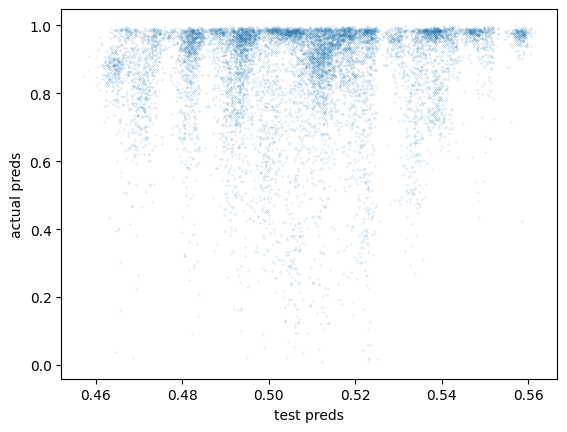

In [38]:
plt.scatter(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy(), s=0.01)
plt.xlabel("test preds")
plt.ylabel("actual preds")

In [39]:
# plt.scatter(test_preds.view(-1).detach().cpu().numpy(), label.view(-1)[test_idx].detach().cpu().numpy()) # old one